<a href="https://colab.research.google.com/github/rohitshshende0/time_series_forecasting/blob/main/BitPredict_Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BitPredict 💰📈 Project: Time series forecasting in TensorFlow

The goal of this notebook is working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

Welcome to Project, BitPredict 💰📈!

> 🔑 **Note:** ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

steps we're going to follow

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module
* Format data for a time series problem
  * Creating training and test sets (the wrong way)
  * Creating training and test sets (the right way)
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate (more than one variable) data
* Evaluating a time series forecasting model
* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* Creating a modelling checkpoint to save the best performing model during training
* Making predictions (forecasts) with a time series model
* Creating prediction intervals for time series model forecasts
* Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
* Demonstrating why forecasting in an open system is BS (the turkey problem)

## Check for GPU

In order for our deep learning models to run as fast as possible, we'll need access to a GPU.

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dbac334f-bc56-7761-19fc-9bcf38415cbe)


## Get data
We're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [ ]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-07-15 16:04:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-07-15 16:04:00 (7.40 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in **CSV (comma separated values)** format (a very common data format for time series), we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [ ]:
# Import with pandas
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


Looking good! Let's get some more info.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

In [ ]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seaonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Much better!

But that's only five days worth of Bitcoin prices, let's plot everything we've got.

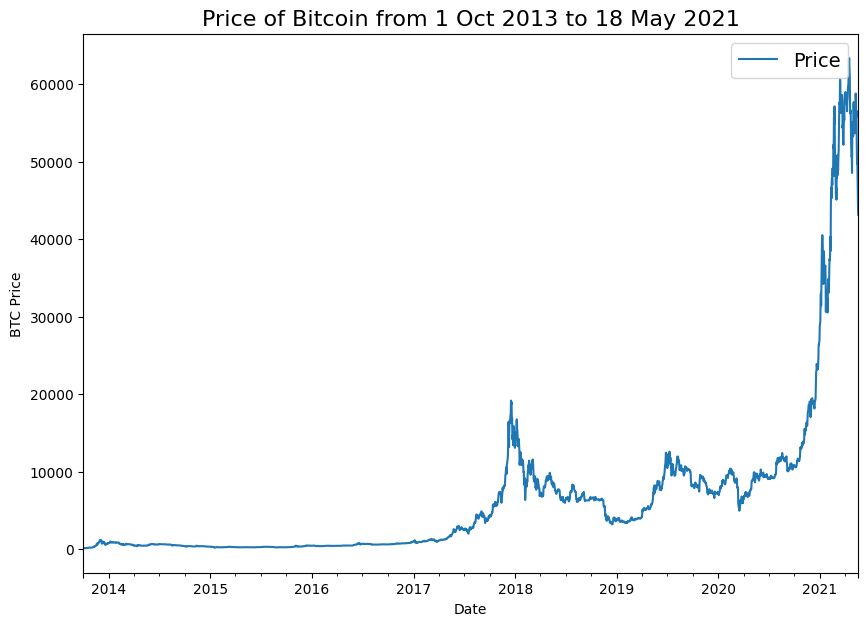

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

Woah, looks like it would've been a good idea to buy Bitcoin back in 2014.

### Importing time series data with Python's CSV module

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.


In [ ]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Beautiful! Now, let's see how things look.

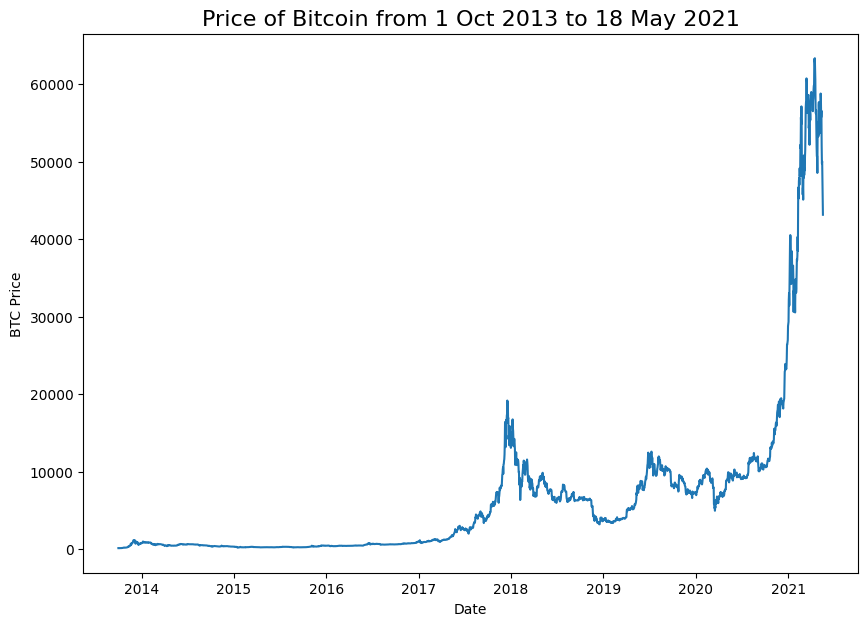

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

## Format Data Part 1: Creatining train and test sets for time series data



### Create train & test sets for time series (the wrong way)

Okay, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables).





In [ ]:
bitcoin_prices[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

And now we'll use the ever faithful `train_test_split` from Scikit-Learn to create our train and test sets.

In [ ]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

Looks like the splits worked well, but let's not trust numbers on a page, let's visualize, visualize, visualize!

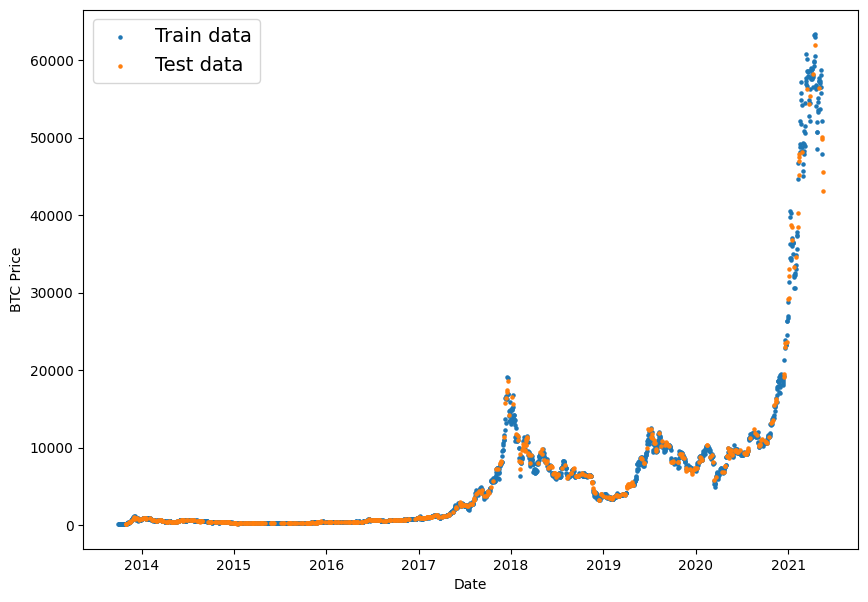

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Hmmm... what's wrong with this plot?

With this in mind, our seen data (training set) is what?

Prices of Bitcoin in the past.

And our unseen data (test set) is?

Prices of Bitcoin in the future.

Does the plot above reflect this?

No.

Our test data is scattered all throughout the training data.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the time factor into account.

To fix this, we've got to split our data in a way that reflects what we're actually trying to do.

We need to split our historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).

### Create train & test sets for time series (the right way)


To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.


In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

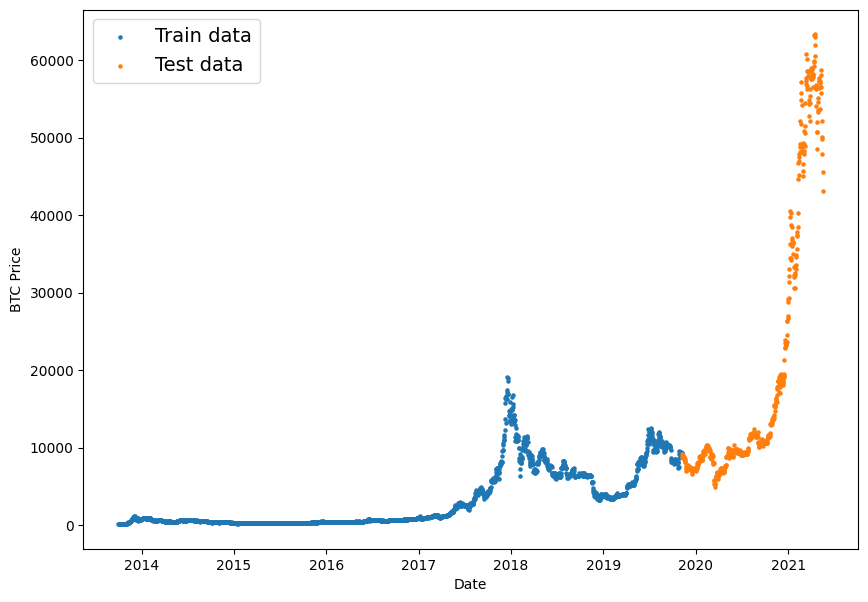

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

That looks much better!

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can guage how our model might perform on *actual* future data.

### Create a plotting function

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

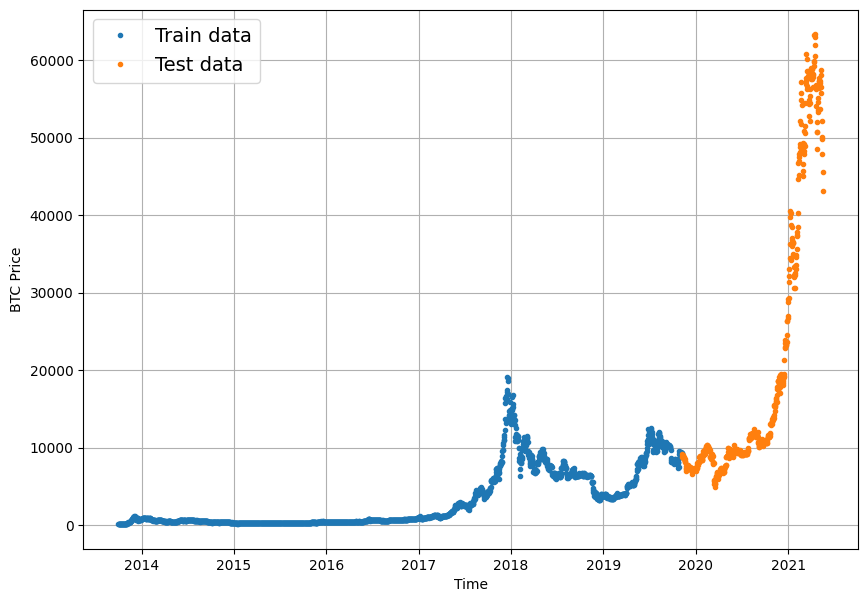

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

Looking good!

Time for some modelling experiments.

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA|
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

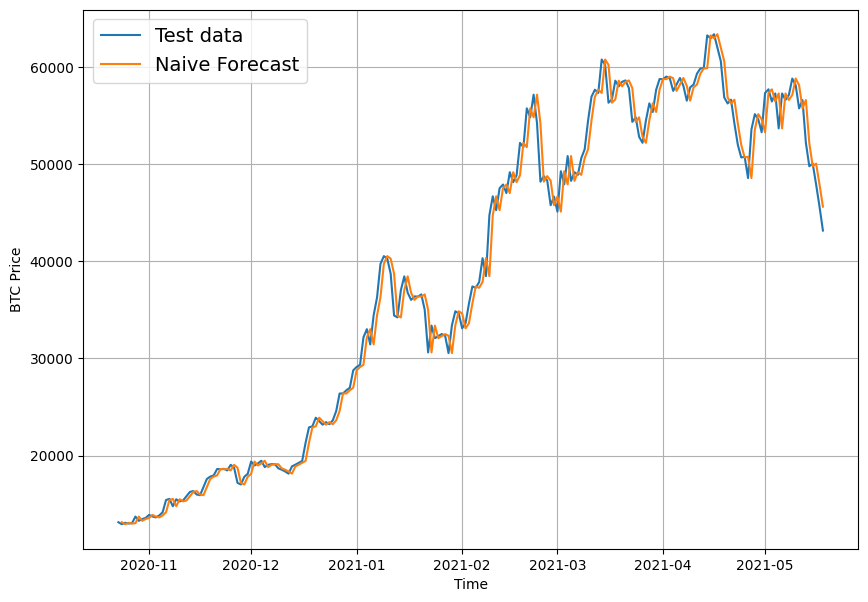

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

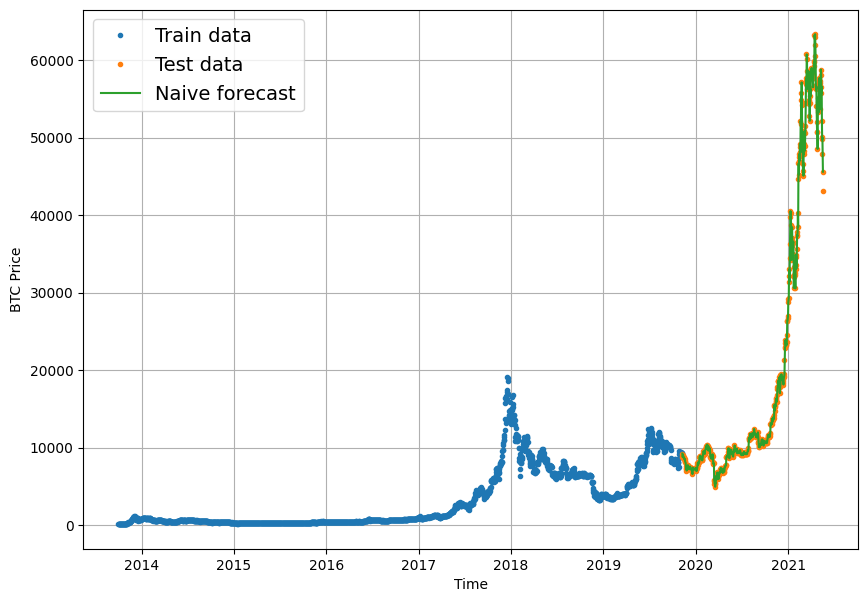

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well.

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

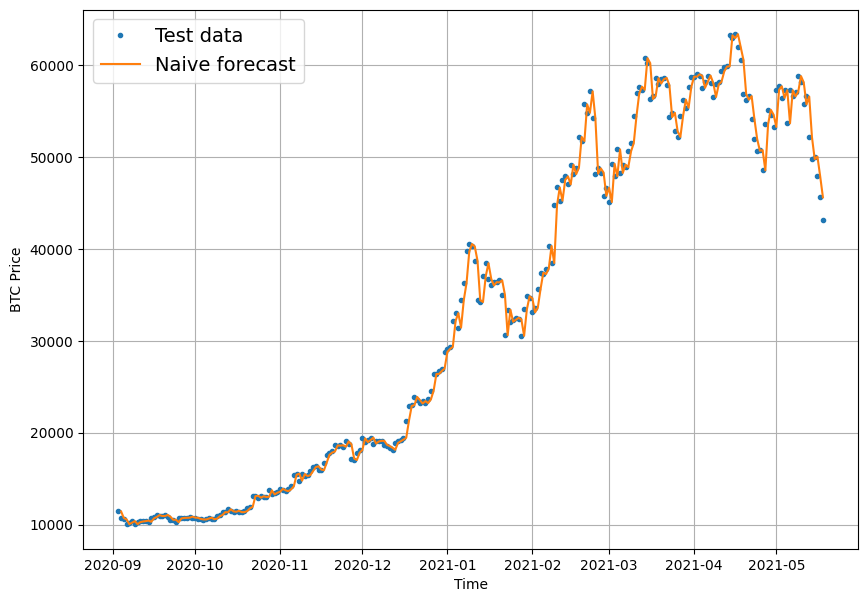

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

## Evaluating a time series model

Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.

In [ ]:
# Let's get TensorFlow!
import tensorflow as tf

And since TensorFlow doesn't have a ready made version of MASE (mean aboslute scaled error), how about we create our own?

We'll take inspiration from [sktime](https://github.com/alan-turing-institute/sktime)'s (Scikit-Learn for time series) [`MeanAbsoluteScaledError`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.

In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

Let's put each of our different evaluation metrics together into a function.

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Looking good! Let's test our function on the naive forecast

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

In [ ]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $567

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

Now we'll write a function to take in an array and turn it into a window and horizon.

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Oh yeah, that's what I'm talking about!

Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets


In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizaiton and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2162.9172 - mae: 2162.9172  

18/18 [==============================] - 6s 46ms/step - loss: 2162.9172 - mae: 2162.9172 - val_loss: 1386.7466 - val_mae: 1386.7465
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 454.9625 - mae: 454.9625 - val_loss: 2176.8040 - val_mae: 2176.8040
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 283.0134 - mae: 283.0134

18/18 [==============================] - 1s 30ms/step - loss: 282.2809 - mae: 282.2809 - val_loss: 1292.8359 - val_mae: 1292.8359
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 284.8721 - mae: 284.8721

18/18 [==============================] - 1s 30ms/step - loss: 226.2888 - mae: 226.2888 - val_loss: 1179.5625 - val_mae: 1179.5625
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 228.6282 - mae: 228.6282

18/18 [==============================] - 1s 31ms/step - loss: 214.3280 - mae: 214.3280 - val_loss: 1168.5482 - val_mae: 1168.5482
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 159.4835 - mae: 159.4835

18/18 [==============================] - 0s 29ms/step - loss: 203.3476 - mae: 203.3476 - val_loss: 1127.8381 - val_mae: 1127.8381
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 199.1965 - mae: 199.1965

18/18 [==============================] - 1s 29ms/step - loss: 198.4964 - mae: 198.4964 - val_loss: 1123.0243 - val_mae: 1123.0243
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 174.6356 - mae: 174.6356

18/18 [==============================] - 1s 39ms/step - loss: 191.5588 - mae: 191.5588 - val_loss: 1048.2572 - val_mae: 1048.2572
Epoch 9/100
14/18 [======================>.......] - ETA: 0s - loss: 178.2814 - mae: 178.2814

18/18 [==============================] - 1s 42ms/step - loss: 182.0629 - mae: 182.0629 - val_loss: 1027.1394 - val_mae: 1027.1394
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 173.9785 - mae: 173.9785

18/18 [==============================] - 1s 58ms/step - loss: 177.9880 - mae: 177.9880 - val_loss: 974.8635 - val_mae: 974.8635
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 198.0217 - mae: 198.0217

18/18 [==============================] - 1s 30ms/step - loss: 172.4818 - mae: 172.4818 - val_loss: 946.1254 - val_mae: 946.1254
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 168.1620 - mae: 168.1620 - val_loss: 1014.8439 - val_mae: 1014.8439
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 133.2082 - mae: 133.2082

18/18 [==============================] - 0s 29ms/step - loss: 165.3733 - mae: 165.3733 - val_loss: 906.9722 - val_mae: 906.9722
Epoch 14/100
18/18 [==============================] - 0s 5ms/step - loss: 159.2868 - mae: 159.2868 - val_loss: 914.6960 - val_mae: 914.6960
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 157.1729 - mae: 157.1729 - val_loss: 981.9726 - val_mae: 981.9726
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 148.8320 - mae: 148.8320

18/18 [==============================] - 1s 29ms/step - loss: 154.5773 - mae: 154.5773 - val_loss: 844.1248 - val_mae: 844.1248
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 140.7776 - mae: 140.7776

18/18 [==============================] - 0s 29ms/step - loss: 146.9816 - mae: 146.9816 - val_loss: 840.5419 - val_mae: 840.5419
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 154.8053 - mae: 154.8053

18/18 [==============================] - 0s 28ms/step - loss: 143.0995 - mae: 143.0995 - val_loss: 827.0017 - val_mae: 827.0017
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 81.7437 - mae: 81.7437

18/18 [==============================] - 0s 29ms/step - loss: 138.2517 - mae: 138.2517 - val_loss: 794.4343 - val_mae: 794.4343
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 148.1194 - mae: 148.1194

18/18 [==============================] - 0s 29ms/step - loss: 138.5909 - mae: 138.5909 - val_loss: 756.5896 - val_mae: 756.5896
Epoch 21/100
18/18 [==============================] - 0s 4ms/step - loss: 138.6422 - mae: 138.6422 - val_loss: 771.5577 - val_mae: 771.5577
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 188.4505 - mae: 188.4505

18/18 [==============================] - 1s 30ms/step - loss: 130.5699 - mae: 130.5699 - val_loss: 735.3840 - val_mae: 735.3840
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 136.0460 - mae: 136.0460

18/18 [==============================] - 0s 29ms/step - loss: 128.4738 - mae: 128.4738 - val_loss: 709.5502 - val_mae: 709.5502
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 136.3673 - mae: 136.3673

18/18 [==============================] - 1s 31ms/step - loss: 127.8850 - mae: 127.8850 - val_loss: 702.9477 - val_mae: 702.9477
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 128.7332 - mae: 128.7332

18/18 [==============================] - 1s 31ms/step - loss: 126.0479 - mae: 126.0479 - val_loss: 690.7920 - val_mae: 690.7920
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 122.8610 - mae: 122.8610

18/18 [==============================] - 1s 29ms/step - loss: 123.6424 - mae: 123.6424 - val_loss: 681.8893 - val_mae: 681.8893
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 173.5412 - mae: 173.5412

18/18 [==============================] - 0s 28ms/step - loss: 124.4620 - mae: 124.4620 - val_loss: 670.3152 - val_mae: 670.3152
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 116.5502 - mae: 116.5502

18/18 [==============================] - 0s 28ms/step - loss: 120.5979 - mae: 120.5979 - val_loss: 664.0165 - val_mae: 664.0165
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 113.6126 - mae: 113.6126

18/18 [==============================] - 1s 42ms/step - loss: 120.3614 - mae: 120.3614 - val_loss: 657.3375 - val_mae: 657.3375
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 124.0296 - mae: 124.0296 - val_loss: 659.8574 - val_mae: 659.8574
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 119.3045 - mae: 119.3045 - val_loss: 706.7964 - val_mae: 706.7964
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 121.1980 - mae: 121.1980

18/18 [==============================] - 0s 29ms/step - loss: 122.1625 - mae: 122.1625 - val_loss: 642.3566 - val_mae: 642.3566
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 119.9855 - mae: 119.9855 - val_loss: 669.7748 - val_mae: 669.7748
Epoch 34/100
18/18 [==============================] - 0s 4ms/step - loss: 121.4490 - mae: 121.4490 - val_loss: 647.1757 - val_mae: 647.1757
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0390 - mae: 116.0390 - val_loss: 685.6661 - val_mae: 685.6661
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 169.4867 - mae: 169.4867

18/18 [==============================] - 0s 29ms/step - loss: 117.9061 - mae: 117.9061 - val_loss: 623.8185 - val_mae: 623.8185
Epoch 37/100
18/18 [==============================] - 0s 4ms/step - loss: 116.0858 - mae: 116.0858 - val_loss: 626.0096 - val_mae: 626.0096
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 104.7780 - mae: 104.7780

18/18 [==============================] - 1s 38ms/step - loss: 115.2378 - mae: 115.2378 - val_loss: 618.9998 - val_mae: 618.9998
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 117.3857 - mae: 117.3857

18/18 [==============================] - 1s 43ms/step - loss: 114.6291 - mae: 114.6291 - val_loss: 614.4763 - val_mae: 614.4763
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 113.7450 - mae: 113.7450 - val_loss: 625.5216 - val_mae: 625.5216
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 113.9948 - mae: 113.9948 - val_loss: 672.0029 - val_mae: 672.0029
Epoch 42/100
15/18 [========================>.....] - ETA: 0s - loss: 117.4845 - mae: 117.4845

18/18 [==============================] - 1s 42ms/step - loss: 122.5017 - mae: 122.5017 - val_loss: 611.6147 - val_mae: 611.6147
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 116.1562 - mae: 116.1562 - val_loss: 654.2524 - val_mae: 654.2524
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 116.7589 - mae: 116.7589 - val_loss: 619.0703 - val_mae: 619.0703
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3563 - mae: 112.3563 - val_loss: 629.2576 - val_mae: 629.2576
Epoch 46/100
18/18 [==============================] - 0s 4ms/step - loss: 112.8494 - mae: 112.8494 - val_loss: 646.2263 - val_mae: 646.2263
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 113.5256 - mae: 113.5256 - val_loss: 635.2059 - val_mae: 635.2059
Epoch 48/100
 1/18 [>.............................] - ETA: 0s - loss: 107.5877 - mae: 107.5877

18/18 [==============================] - 0s 29ms/step - loss: 111.4900 - mae: 111.4900 - val_loss: 602.5286 - val_mae: 602.5286
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2943 - mae: 113.2943 - val_loss: 679.9625 - val_mae: 679.9625
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 117.8644 - mae: 117.8644 - val_loss: 627.5502 - val_mae: 627.5502
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 113.0937 - mae: 113.0937 - val_loss: 603.1899 - val_mae: 603.1899
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 116.2368 - mae: 116.2368

18/18 [==============================] - 0s 29ms/step - loss: 112.8264 - mae: 112.8264 - val_loss: 589.8922 - val_mae: 589.8922
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6558 - mae: 114.6558 - val_loss: 666.7283 - val_mae: 666.7283
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 117.7613 - mae: 117.7613 - val_loss: 627.0703 - val_mae: 627.0703
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7572 - mae: 112.7572 - val_loss: 590.7596 - val_mae: 590.7596
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 110.2711 - mae: 110.2711 - val_loss: 753.0223 - val_mae: 753.0223
Epoch 57/100
 1/18 [>.............................] - ETA: 0s - loss: 115.5029 - mae: 115.5029

18/18 [==============================] - 1s 29ms/step - loss: 113.3692 - mae: 113.3692 - val_loss: 587.0542 - val_mae: 587.0542
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2984 - mae: 111.2984 - val_loss: 598.7938 - val_mae: 598.7938
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7295 - mae: 109.7295 - val_loss: 618.1269 - val_mae: 618.1269
Epoch 60/100
18/18 [==============================] - 0s 4ms/step - loss: 115.5472 - mae: 115.5472 - val_loss: 632.9457 - val_mae: 632.9457
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 138.8605 - mae: 138.8605

18/18 [==============================] - 0s 28ms/step - loss: 112.0167 - mae: 112.0167 - val_loss: 584.7684 - val_mae: 584.7684
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 70.0836 - mae: 70.0836

18/18 [==============================] - 1s 29ms/step - loss: 108.1414 - mae: 108.1414 - val_loss: 581.3059 - val_mae: 581.3059
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8783 - mae: 109.8783 - val_loss: 609.0516 - val_mae: 609.0516
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9076 - mae: 109.9076 - val_loss: 595.0824 - val_mae: 595.0824
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 109.7700 - mae: 109.7700 - val_loss: 585.6348 - val_mae: 585.6348
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 109.0855 - mae: 109.0855 - val_loss: 592.5486 - val_mae: 592.5486
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 109.9167 - mae: 109.9167 - val_loss: 709.4754 - val_mae: 709.4754
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6121 - mae: 110.6121 - val_loss: 588.0728 - val_mae: 588.0728
Epoch 69/100
18/18 [============

18/18 [==============================] - 0s 28ms/step - loss: 109.4531 - mae: 109.4531 - val_loss: 579.0470 - val_mae: 579.0470
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 95.3808 - mae: 95.3808

18/18 [==============================] - 0s 29ms/step - loss: 110.8086 - mae: 110.8086 - val_loss: 577.0276 - val_mae: 577.0276
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2186 - mae: 113.2186 - val_loss: 620.3676 - val_mae: 620.3676
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 109.5087 - mae: 109.5087 - val_loss: 578.2038 - val_mae: 578.2038
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 109.0086 - mae: 109.0086 - val_loss: 579.9355 - val_mae: 579.9355
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 112.7896 - mae: 112.7896 - val_loss: 599.6036 - val_mae: 599.6036
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 110.4673 - mae: 110.4673 - val_loss: 583.7695 - val_mae: 583.7695
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 103.6311 - mae: 103.6311

18/18 [==============================] - 0s 29ms/step - loss: 109.3843 - mae: 109.3843 - val_loss: 575.0323 - val_mae: 575.0323
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 108.0086 - mae: 108.0086 - val_loss: 600.1682 - val_mae: 600.1682
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 113.6721 - mae: 113.6721 - val_loss: 599.5398 - val_mae: 599.5398
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 108.4571 - mae: 108.4571 - val_loss: 581.9719 - val_mae: 581.9719
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 120.5906 - mae: 120.5906 - val_loss: 594.3515 - val_mae: 594.3515
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7910 - mae: 113.7910 - val_loss: 684.6605 - val_mae: 684.6605
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1430 - mae: 115.1430 - val_loss: 578.1232 - val_mae: 578.1232
Epoch 85/100
18/18 [============

18/18 [==============================] - 0s 29ms/step - loss: 111.2650 - mae: 111.2650 - val_loss: 569.7181 - val_mae: 569.7181
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 115.0228 - mae: 115.0228 - val_loss: 588.8447 - val_mae: 588.8447
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 115.4759 - mae: 115.4759 - val_loss: 584.3620 - val_mae: 584.3620
Epoch 94/100
 1/18 [>.............................] - ETA: 0s - loss: 137.9776 - mae: 137.9776

18/18 [==============================] - 0s 29ms/step - loss: 109.8326 - mae: 109.8326 - val_loss: 569.4764 - val_mae: 569.4764
Epoch 95/100
18/18 [==============================] - 0s 4ms/step - loss: 105.7799 - mae: 105.7799 - val_loss: 575.0900 - val_mae: 575.0900
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5444 - mae: 107.5444 - val_loss: 579.8148 - val_mae: 579.8148
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 107.1212 - mae: 107.1212 - val_loss: 569.6318 - val_mae: 569.6318
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 106.4296 - mae: 106.4296 - val_loss: 575.7752 - val_mae: 575.7752
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 107.2839 - mae: 107.2839 - val_loss: 575.9394 - val_mae: 575.9394
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 112.2850 - mae: 112.2850 - val_loss: 640.3007 - val_mae: 640.3007


Because of the small size of our data (less than 3000 total samples), the model trains very fast.

Let's evaluate it.

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 640.3007 - mae: 640.3007


[640.3006591796875, 640.3006591796875]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 569.4763 - mae: 569.4763


[569.476318359375, 569.476318359375]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8875.137, 8772.739, 9029.957, 8820.141, 8724.959, 8729.551,
        8704.713, 8527.44 , 8457.563, 8532.098], dtype=float32)>)

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 569.4763,
 'mse': 1178156.2,
 'rmse': 1085.4291,
 'mape': 2.5600934,
 'mase': 1.0004121}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

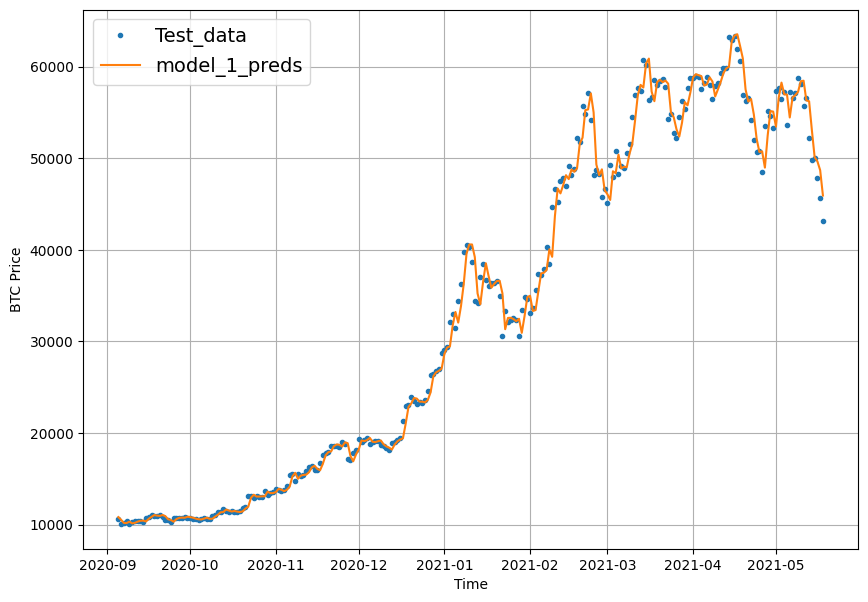

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

A naïve model is currently beating our handcrafted deep learning model.

We can't let this happen.

Let's continue our modelling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

In [ ]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

Data prepared!

Now let's construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [ ]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 650.6580


650.657958984375

In [ ]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 609.3426


609.3425903320312

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 7ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 609.3426,
 'mse': 1268504.8,
 'rmse': 1126.2792,
 'mape': 2.7491498,
 'mase': 1.0651368}

In [ ]:
model_1_results

{'mae': 569.4763,
 'mse': 1178156.2,
 'rmse': 1085.4291,
 'mape': 2.5600934,
 'mase': 1.0004121}

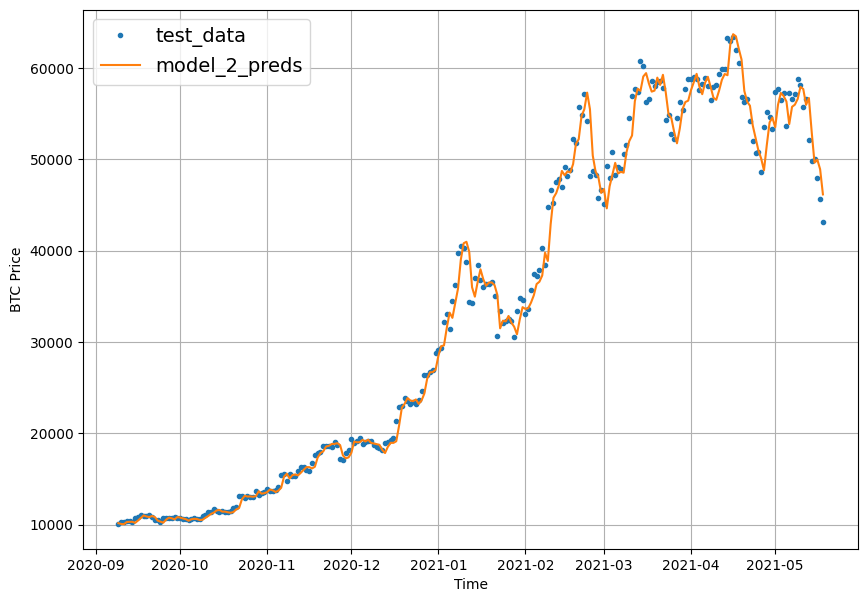

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1364.0182


1364.0181884765625

To compare apples to apples (best performing model to best performing model), we've got to load in the best version of `model_3`.

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1246.7476


1246.74755859375

In [ ]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9417.42 , 9662.496, 9400.967, 9468.804, 9638.953, 9461.511,
        9581.833],
       [9286.993, 9289.391, 9118.693, 9079.377, 9306.15 , 9068.144,
        9262.949],
       [9193.358, 9065.141, 8781.496, 8814.048, 8999.311, 8967.368,
        9110.347],
       [9186.849, 9109.682, 8982.706, 8874.541, 9024.443, 9128.928,
        9387.709],
       [8916.941, 9088.666, 9060.739, 8938.755, 9044.026, 9195.671,
        9161.399]], dtype=float32)>

In [ ]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  725.6398  ,   450.4153  ,   285.86566 ,   472.67075 ,
          503.6805  ,   578.1439  ,   535.6286  ,   527.1691  ,
          551.0529  ,   593.5677  ,   797.5068  ,   819.3941  ,
          913.5357  ,   899.3211  ,   624.4385  ,   275.9968  ,
          264.15848 ,   355.43646 ,   267.1933  ,   313.89963 ,
          146.29562 ,   201.67976 ,   363.0166  ,   370.67648 ,
          254.34752 ,   183.5367  ,   174.62291 ,   144.77385 ,
          112.11056 ,   174.86244 ,   316.60367 ,   409.0249  ,
          349.85483 ,   357.3775  ,   327.562   ,   305.37192 ,
          352.07275 ,   266.24887 ,   217.22551 ,   248.42683 ,
          462.70377 ,   134.9509  ,   123.24177 ,    80.66999 ,
          118.64704 ,   137.17635 ,   158.37375 ,   135.11035 ,
          152.8909  ,   121.029015,   105.17369 ,   102.36    ,
          173.85979 ,   232.384   ,   282.33154 ,   414.26157 ,
          498.70883 ,   524.73096 ,   490.5734  ,   463.32687 ,
          356.1596  ,   235.73424

## Make our evaluation function work for larger horizons

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1246.7476,
 'mse': 5329691.5,
 'rmse': 1430.9207,
 'mape': 5.664561,
 'mase': 2.2185173}

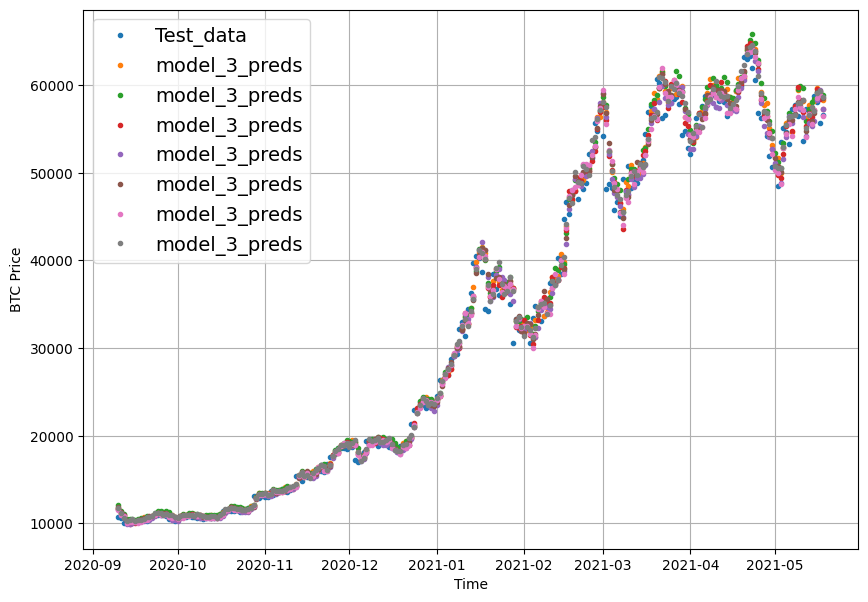

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

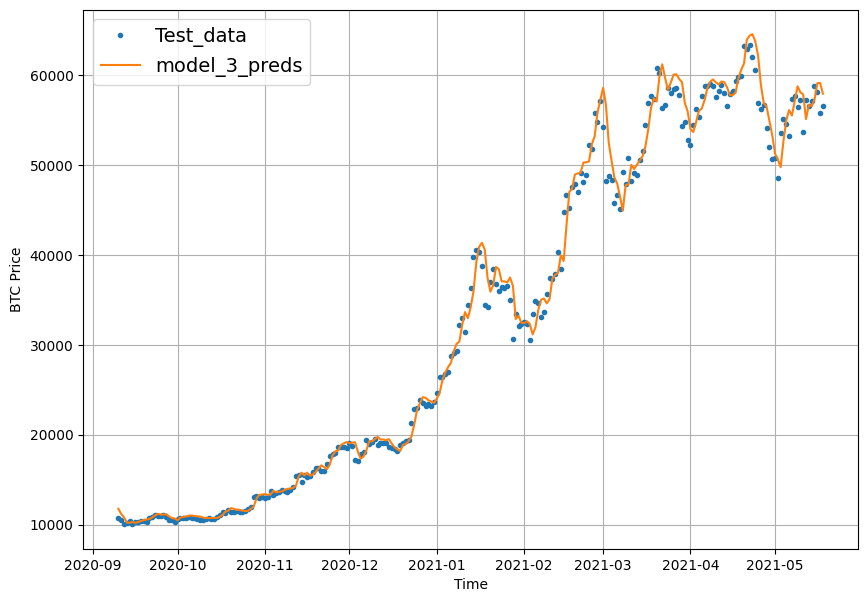

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing best so far?

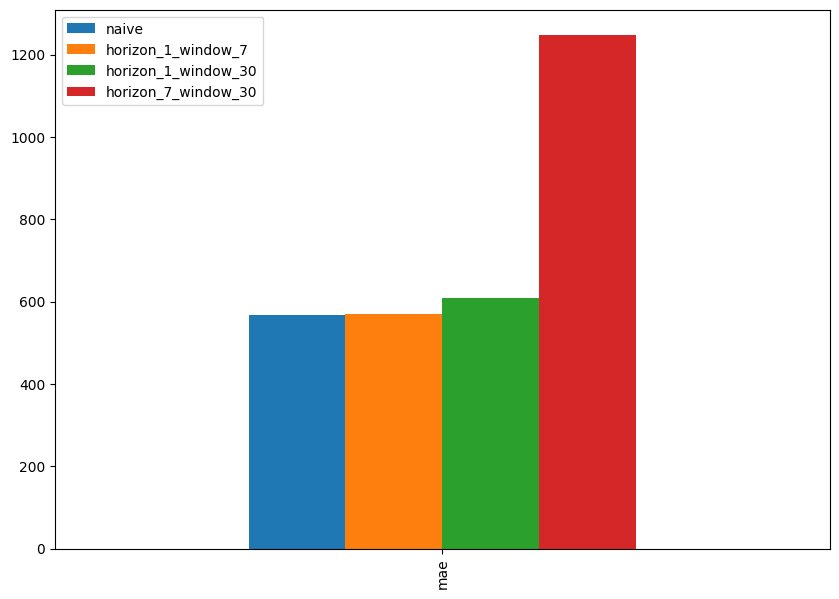

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).


## Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In [ ]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

Let's try it out.

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 569.6099


569.60986328125

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8858.559 , 8764.223 , 8994.5205, 8754.321 , 8723.35  , 8739.942 ,
       8649.929 , 8519.706 , 8444.741 , 8504.745 ], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.60986,
 'mse': 1176596.0,
 'rmse': 1084.7101,
 'mape': 2.5490556,
 'mase': 1.0006467}

## Model 5: RNN (LSTM)

In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 584.5920


584.5919799804688

Now we've got the best performing LSTM model loaded in, let's make predictions with it and evaluate them.

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8866.59 , 8767.13 , 8925.582, 8732.418, 8739.222, 8688.237,
       8635.922, 8514.293, 8424.319, 8471.907], dtype=float32)>

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 584.592,
 'mse': 1208159.5,
 'rmse': 1099.1631,
 'mape': 2.6288302,
 'mase': 1.0269662}

## Make a multivariate time series

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) |

> 🔑 **Note:** Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [ ]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


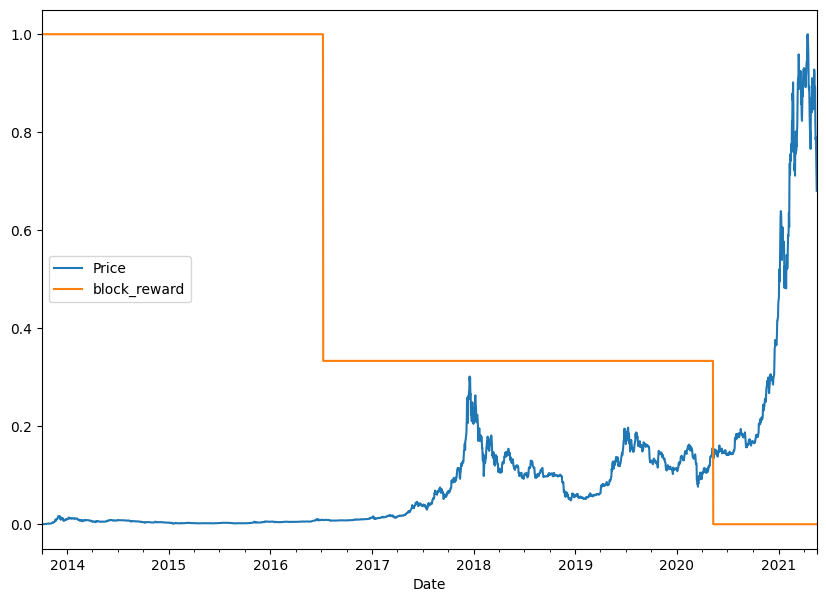

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.


In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [94]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [95]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Training and test multivariate time series datasets made! Time to build a model.

## Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [96]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [97]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 567.5727


567.5726928710938

In [98]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8860.102, 8782.638, 9044.608, 8794.081, 8725.981, 8738.264,
       8691.343, 8523.423, 8459.627, 8534.083], dtype=float32)>

In [99]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.57275,
 'mse': 1166897.4,
 'rmse': 1080.2302,
 'mape': 2.5496976,
 'mase': 0.9970681}

In [100]:
model_1_results

{'mae': 569.4763,
 'mse': 1178156.2,
 'rmse': 1085.4291,
 'mape': 2.5600934,
 'mase': 1.0004121}

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

### Building and testing an N-BEATS block layer

In [101]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

make some dummy inputs and outputs.

In [102]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [103]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [104]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.07110395  0.49453864  0.03755392  0.20709746  0.16411497  0.01062439
  0.1809574 ]
Forecast: 0.5448271036148071


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance

In [105]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [106]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [107]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [108]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Train and test sets ready to go!

Now let's convert them into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.


In [109]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Data prepared! Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

Time to get create the N-BEATS architecture.

### Setting up hyperparameters for N-BEATS algorithm

In [111]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Beautiful! Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

In [112]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [113]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 133: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 233: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 38s, sys: 1.71 s, total: 1min 39s
Wall time: 1min 48s


In [114]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 37ms/step - loss: 581.0303 - mae: 581.0303 - mse: 1167993.2500


[581.0303344726562, 581.0303344726562, 1167993.25]

In [115]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8801.951, 8715.151, 8988.606, 8737.433, 8715.705, 8693.097,
       8656.122, 8443.979, 8437.418, 8484.25 ], dtype=float32)>

In [116]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 581.03033,
 'mse': 1167993.2,
 'rmse': 1080.7373,
 'mape': 2.6382673,
 'mase': 1.0207094}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

You know what would be cool?

If we could plot the N-BEATS model we've crafted.

Well it turns out we can using [`tensorflow.keras.utils.plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

Let's see what it looks like.

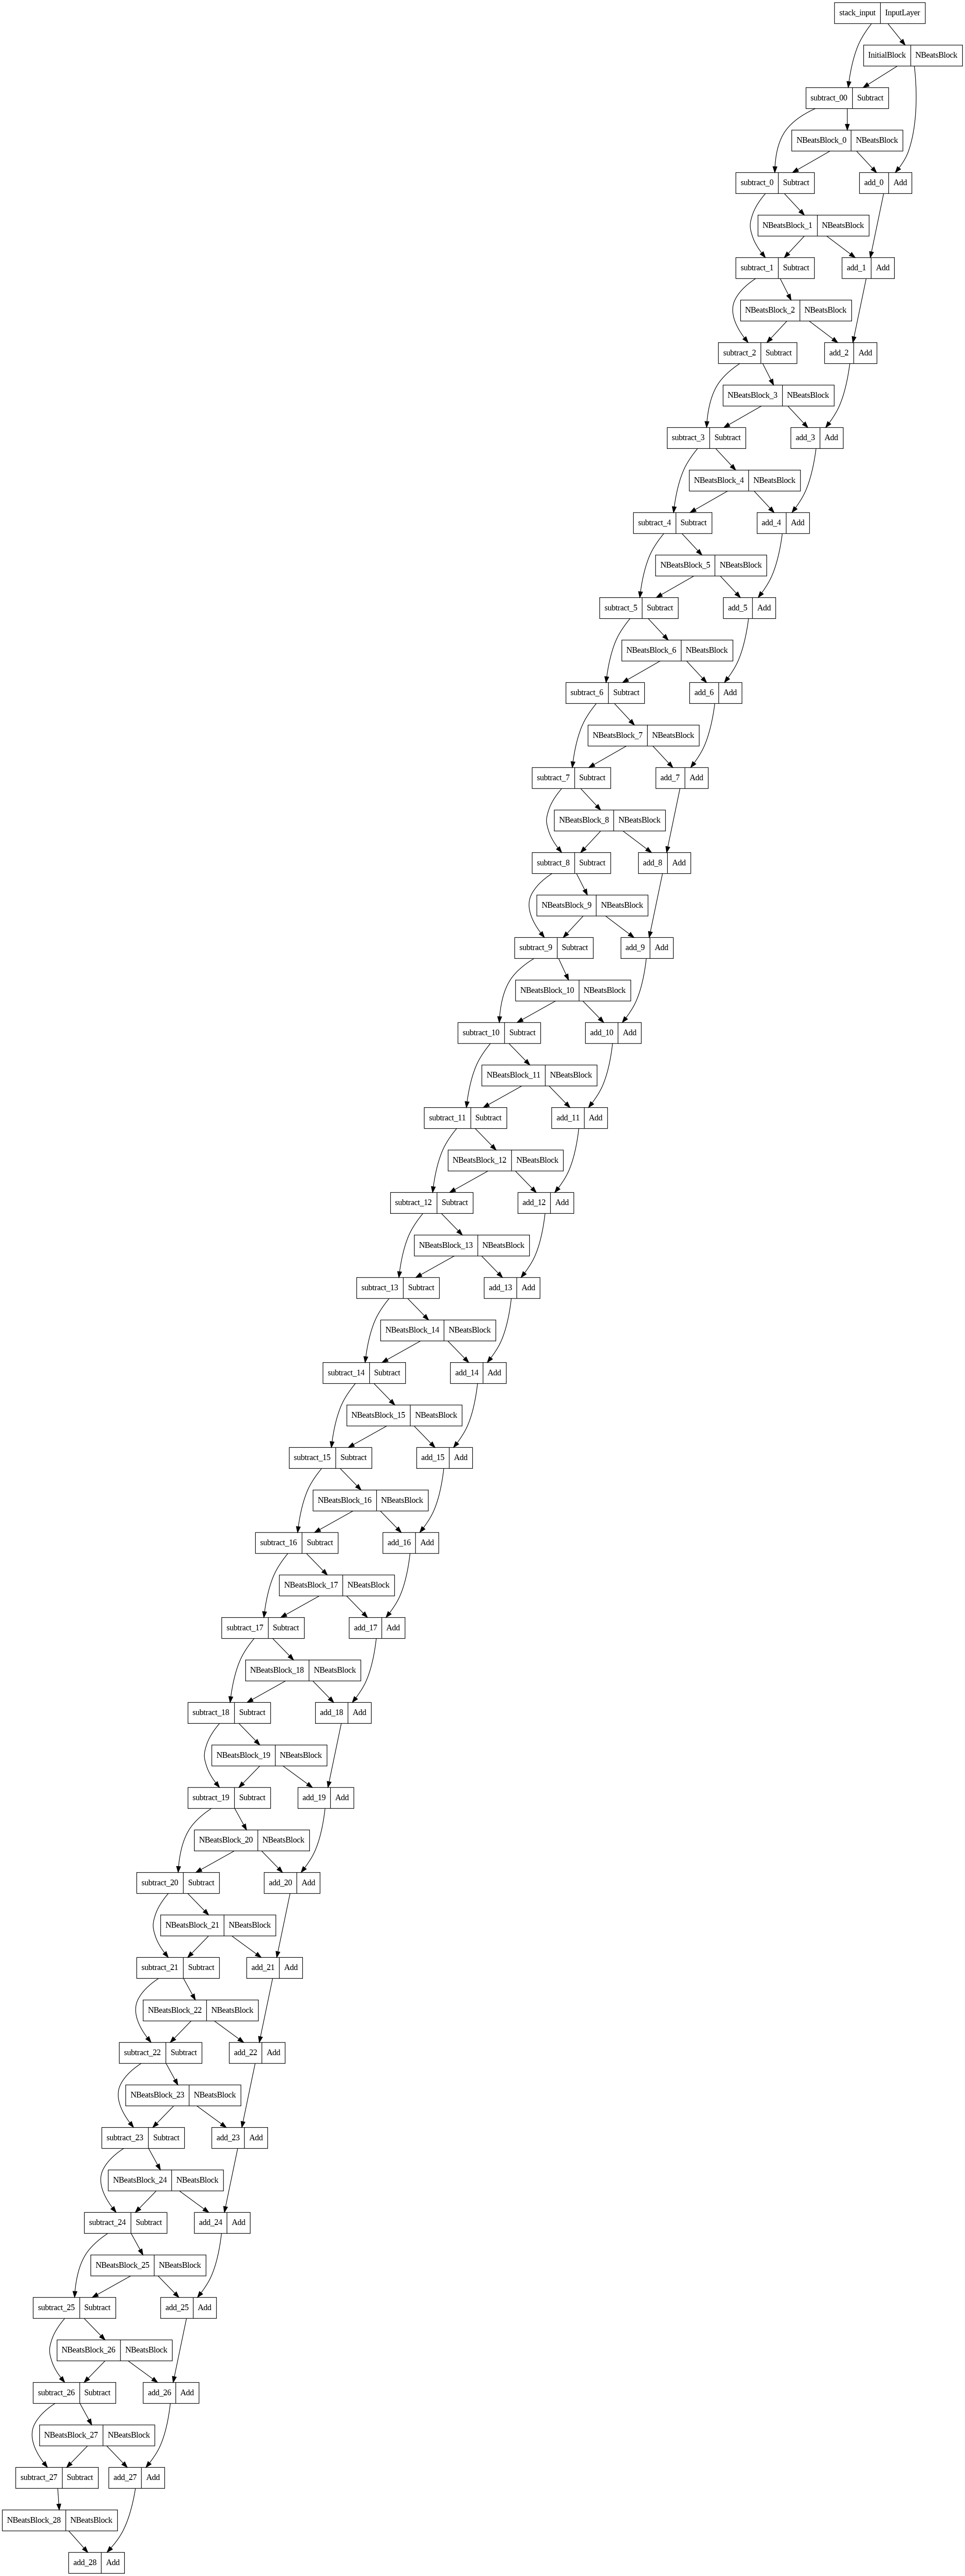

In [117]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [118]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

In [119]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)

In [120]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Ensemble model creator function created!

Let's try it out by running `num_iter=5` runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).

In [122]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 962: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 229: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 329: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 248: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 628: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 728: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 901: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 194: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 294: ReduceLROnPl

### Making predictions with an ensemble model

In [123]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [124]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8792.404 ,  8781.088 ,  9048.737 , ..., 50112.707 , 48265.18  ,
        45982.332 ],
       [ 8779.26  ,  8771.534 ,  9002.877 , ..., 49196.188 , 47207.797 ,
        46276.746 ],
       [ 8779.525 ,  8795.089 ,  9045.516 , ..., 50187.066 , 48226.984 ,
        46252.49  ],
       ...,
       [ 8762.639 ,  8757.927 ,  8987.645 , ..., 49900.41  , 47801.258 ,
        46626.523 ],
       [ 8754.8125,  8759.294 ,  8960.754 , ..., 49510.09  , 48448.81  ,
        45881.25  ],
       [ 8806.869 ,  8796.423 ,  9048.253 , ..., 49462.074 , 48781.883 ,
        45855.96  ]], dtype=float32)>

Now we've got a set of ensemble predictions, we can evaluate them against the ground truth values.

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median (you could also take the mean too but [the median is usually more robust than the mean](https://www.johndcook.com/blog/2009/03/06/student-t-distribution-mean-median/)).

In [125]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 564.97864,
 'mse': 1132350.6,
 'rmse': 1064.1196,
 'mape': 2.5722075,
 'mase': 0.992511}

Nice! Looks like the ensemble model is the best performing model on the MAE metric so far.

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialzed models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

* https://en.wikipedia.org/wiki/1.96
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [126]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

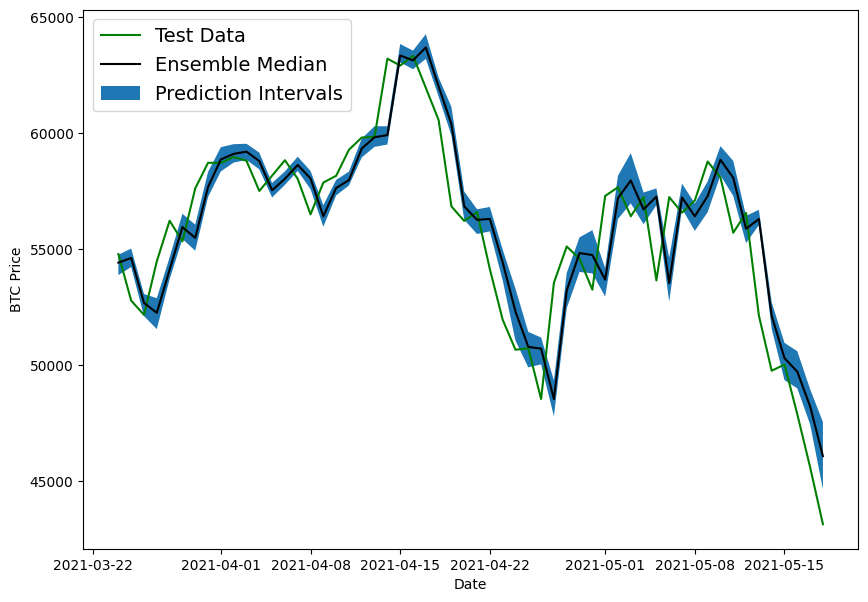

In [127]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model which is capable of predicting into the future!

In [128]:
HORIZON = 1
WINDOW_SIZE = 7

In [129]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [130]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [131]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [132]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [133]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [134]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### Make predictions on the future

In [135]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [136]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

Nice! Time to bring BitPredict 💰📈 to life and make future forecasts of the price of Bitcoin.

In [137]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 213ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 54906.3984375

1/1 [==============================] - 0s 214ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 54906.3984375 ] -> Prediction: 52864.84765625

1/1 [==============================] - 0s 139ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 54906.3984375  52864.84765625] -> Prediction: 48853.92578125

1/1 [==============================] - 0s 147ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 54906.3984375  52864.84765625 48853.92578125] -> Prediction: 48805.06640625

1/1 [==============================] - 0s 69ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 54906.3984375
 52864.84765625 48853.92578125 48805

In [138]:
future_forecast[:10]

[54906.4,
 52864.848,
 48853.926,
 48805.066,
 46748.91,
 45014.207,
 47070.535,
 54508.84,
 52244.33,
 47902.69]

### Plot future forecasts

In [139]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of our forecasted dates will be the last date of our dataset.

In [140]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [141]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [142]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 54906.4  , 52864.848, 48853.926, 48805.066, 46748.91 ,
        45014.207, 47070.535, 54508.84 , 52244.33 , 47902.69 , 47511.41 ,
        46121.387, 45767.812, 49577.652], dtype=float32))

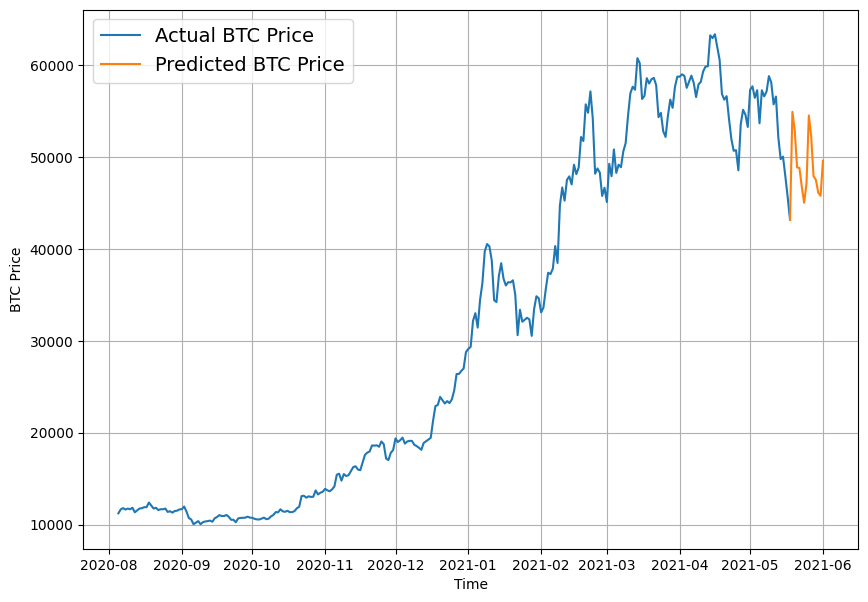

In [143]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem 🦃)


In [144]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [145]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]


Now we've got Bitcoin prices including a turkey problem data point, let's get the timesteps.

In [146]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

Beautiful! Let's see our artificially created turkey problem Bitcoin data.

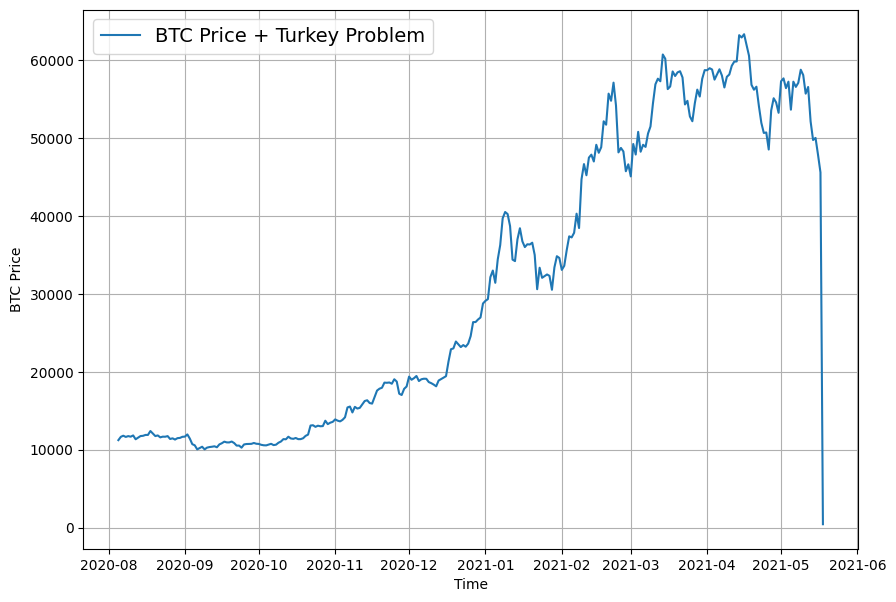

In [148]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [149]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)

In [150]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [151]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 747.2120


747.2120361328125

In [152]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 638.9538


638.9537963867188

Alright, now let's make some predictions with our model and evaluate them on the test data.

In [153]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8824.725, 8765.388, 9047.75 , 8764.087, 8734.755, 8738.4  ,
       8670.529, 8514.966, 8446.253, 8530.292], dtype=float32)>

In [154]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17133.402,
 'mse': 614673340.0,
 'rmse': 23720.807,
 'mape': 121.412125,
 'mase': 26.513992}

In [155]:
model_1_results

{'mae': 569.4763,
 'mse': 1178156.2,
 'rmse': 1085.4291,
 'mape': 2.5600934,
 'mase': 1.0004121}

By changing just one value, the `turkey_model` MAE increases almost 30x over `model_1`.

Finally, we'll visualize the turkey predictions over the test turkey data.

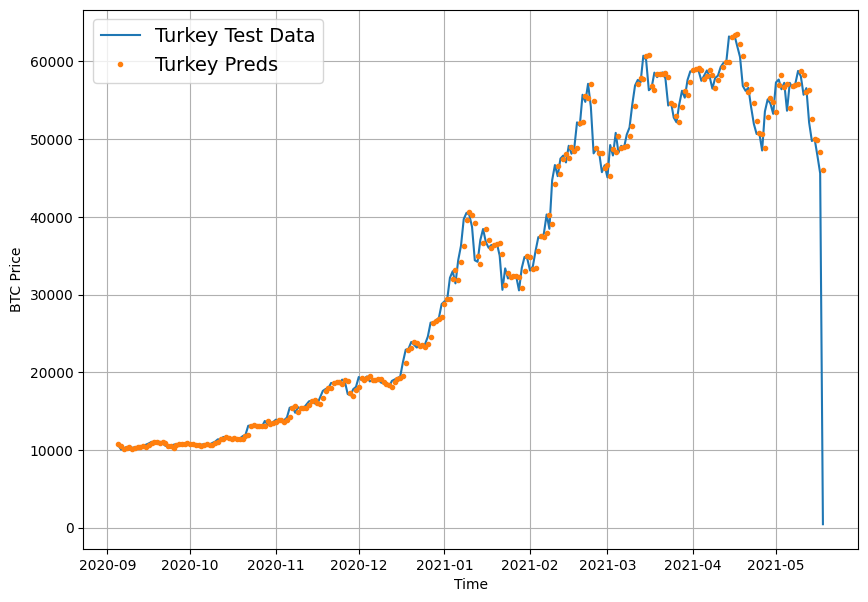

In [156]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare Models

We've trained a bunch of models.

And if anything, we've seen just how poorly machine learning and deep learning models are at forecasting the price of Bitcoin (or any kind of open market value).

To highlight this, let's compare the results of all of the modelling experiments we've performed so far.

In [157]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,569.476318,1.178156e+06,1085.429077,2.560093,1.000412
model_2_dense_w30_h1,609.342590,1.268505e+06,1126.279175,2.749150,1.065137
model_3_dense_w30_h7,1246.747559,5.329692e+06,1430.920654,5.664561,2.218517
model_4_CONV1D,569.609863,1.176596e+06,1084.710083,2.549056,1.000647
model_5_LSTM,584.591980,1.208160e+06,1099.163086,2.628830,1.026966
model_6_multivariate,567.572754,1.166897e+06,1080.230225,2.549698,0.997068
model_8_NBEATs,581.030334,1.167993e+06,1080.737305,2.638267,1.020709
model_9_ensemble,564.978638,1.132351e+06,1064.119629,2.572207,0.992511
model_10_turkey,17133.402344,6.146733e+08,23720.806641,121.412125,26.513992


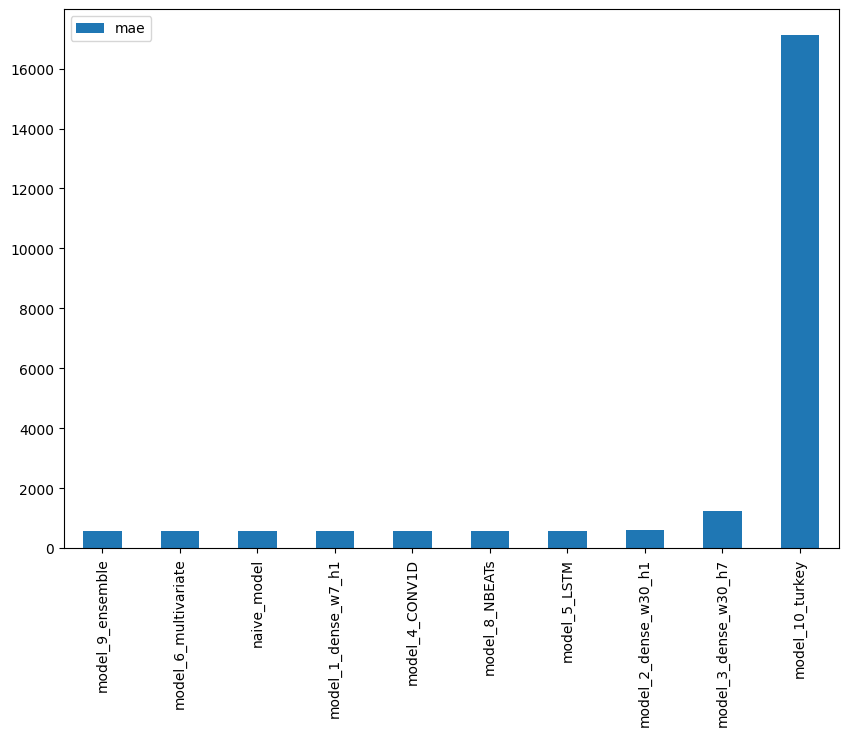

In [158]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

The majority of our deep learning models perform on par or only slightly better than the naive model. And for the turkey model, changing a single data point destroys its performance.